# Loading **data**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from tables.tests.test_suite import test
# Replace with the path to your zip file
train_path = "/content/drive/MyDrive/hateful_memes/train.jsonl" 
val_path = "/content/drive/MyDrive/hateful_memes/dev_seen.jsonl"
test_path = "/content/drive/MyDrive/hateful_memes/test_seen.jsonl"

In [8]:
import pandas as pd

df_t = pd.read_json(train_path, lines=True)
df_val = pd.read_json(val_path, lines=True)
df_test = pd.read_json(test_path, lines=True)


In [ ]:
len(df_test)

1000

In [ ]:
df_t.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [ ]:
df_val.head()

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime


In [9]:
df_t = df_t.loc[:, ['img', 'label']]
df_val = df_val.loc[:, ['img', 'label']]
df_test = df_test.loc[:, ['img', 'label']]

In [ ]:
df_t.head()

,img,label
0,img/42953.png,0
1,img/23058.png,0
2,img/13894.png,0
3,img/37408.png,0
4,img/82403.png,0


In [ ]:
df_val.head()

,img,label
0,img/08291.png,1
1,img/46971.png,1
2,img/03745.png,1
3,img/83745.png,1
4,img/80243.png,1


# Part A

In [10]:
dataset_dir = '/content/drive/MyDrive/hateful_memes'

In [11]:
import pandas as pd
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [12]:
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Get the image path and label from the DataFrame
        image_path = self.df.iloc[index]['img']
        image_path = os.path.join(dataset_dir, image_path)
        label = self.df.iloc[index]['label']
        
        # Open the image using PIL and convert it to RGB
        image = Image.open(image_path).convert('RGB')
        
        
        # Apply the transformation if provided
        if self.transform is not None:
            image = self.transform(image)

        label = torch.tensor(label.astype(float))

        return image, label

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [11]:
dataset_t = CustomDataset(df_t, transform=transform)
train_data = torch.utils.data.DataLoader(dataset_t, batch_size=20, shuffle=True)
train_dataset = dataset_t

In [ ]:
from torch.utils.data import DataLoader, random_split

In [ ]:
# val_percent = 0.4

# # Calculate the number of samples to include in the validation set
# val_size = int(len(dataset_t) * val_percent)

# # Calculate the number of samples to include in the training set
# train_size = len(dataset_t) - val_size

# # Use random_split to split the dataset into training and validation sets
# train_dataset, val_dataset = random_split(dataset_t, [val_size,train_size])

# # Create data loaders for the training and validation sets
# train_data = DataLoader(train_dataset, batch_size=50, shuffle=True)

In [ ]:
dataset_val = CustomDataset(df_val, transform=transform)
val_data = torch.utils.data.DataLoader(dataset_val, batch_size=50, shuffle=True)

In [ ]:
len(val_data)

10

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

40

In [ ]:
print(len(train_dataset))
print(len(dataset_val))

3400
500


In [ ]:
print(len(train_data))
print(len(val_data))

68
10


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

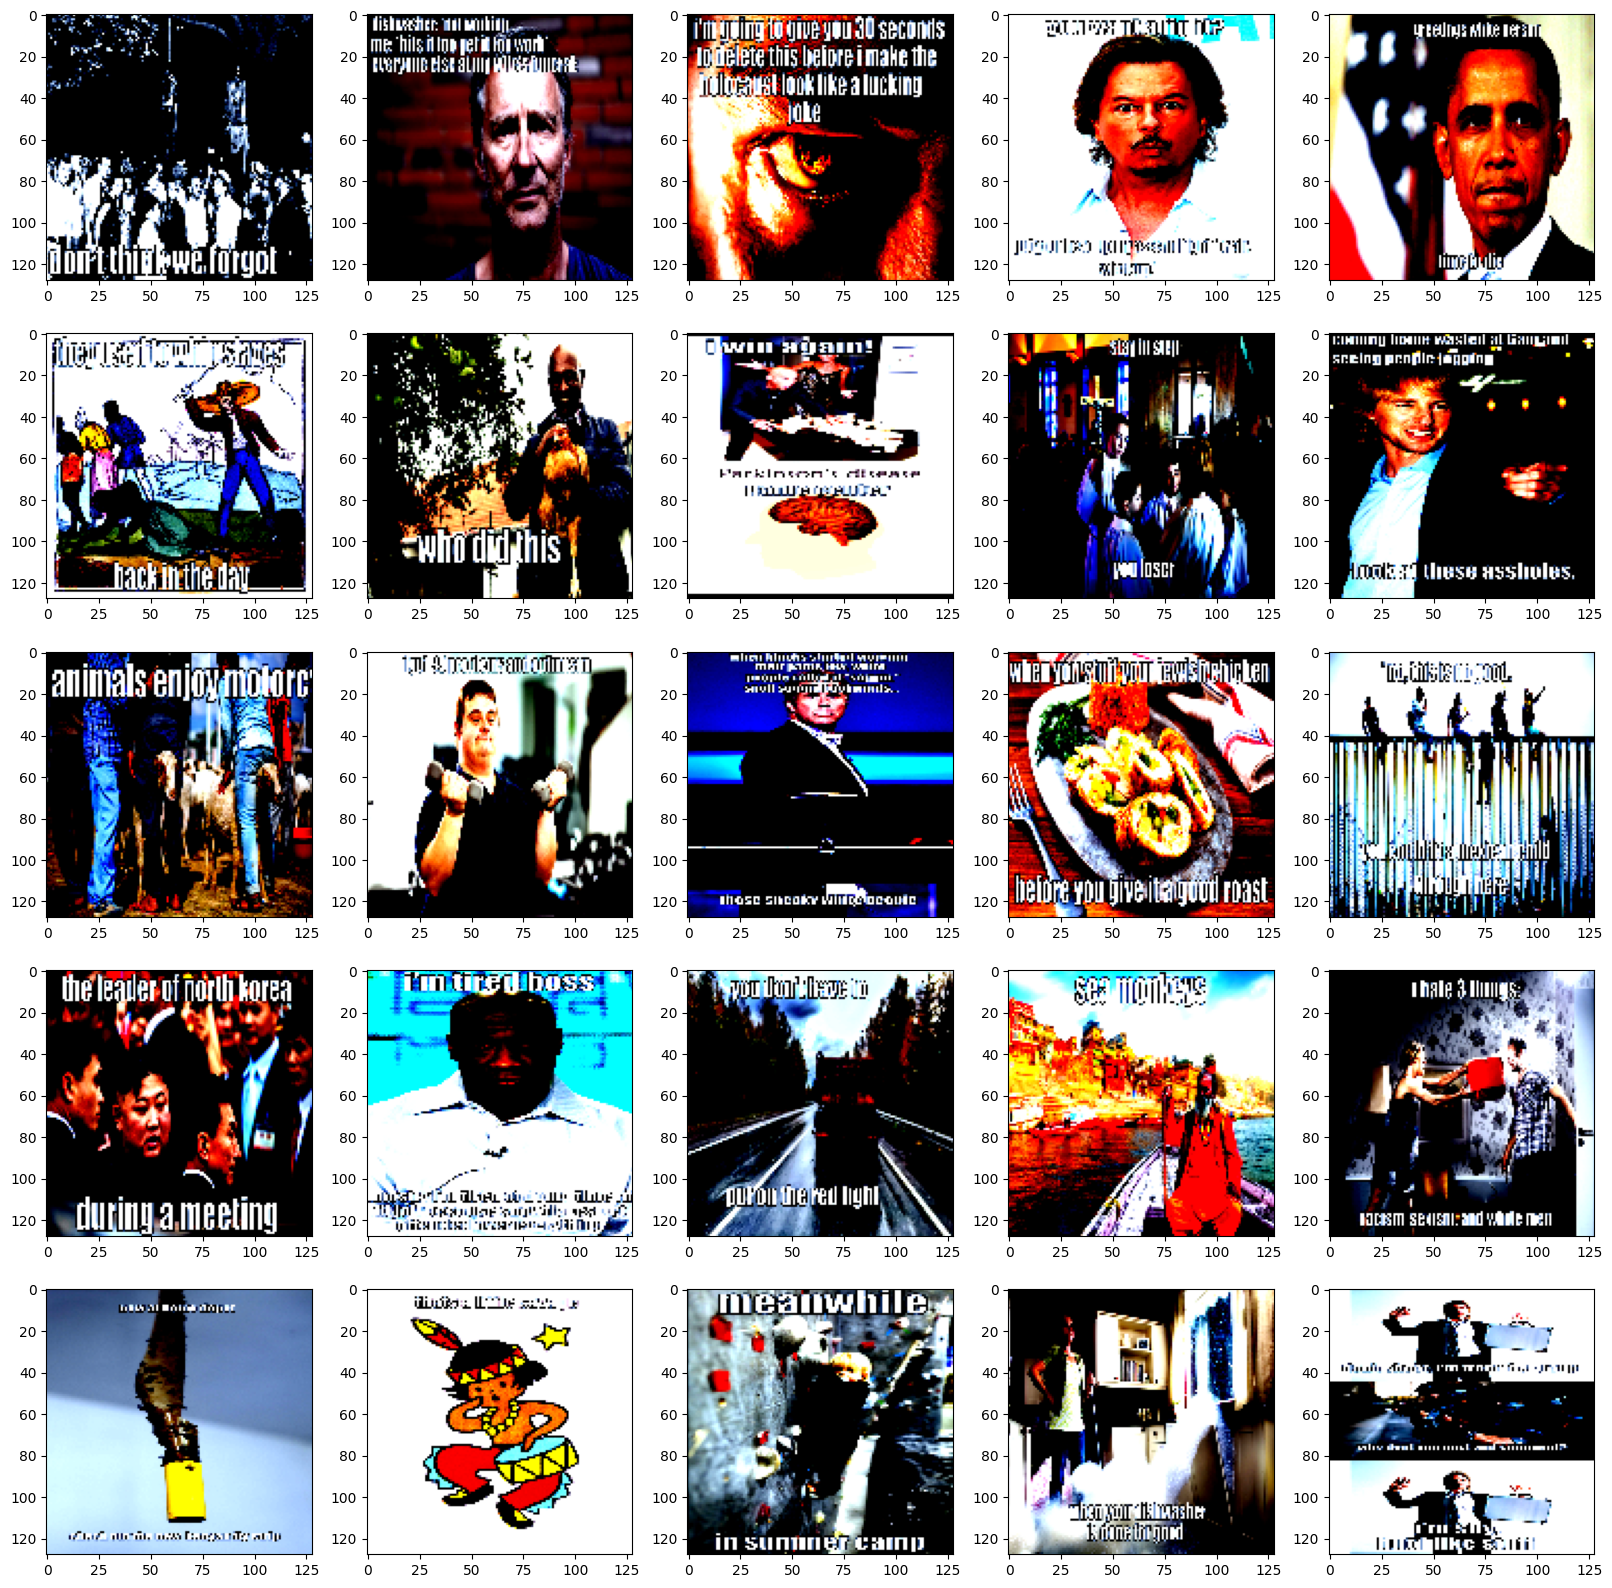

In [ ]:
# Convert images from torch.Tensor to numpy.ndarray and transpose to (batch_size, height, width, channels) format'
images, labels = next(iter(train_data))
images = np.transpose(images.numpy(), (0, 2, 3, 1))

# Create a 5x5 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

# Plot each image in a separate subplot
for i in range(5):
    for j in range(5):
        image_index = i*5 + j
        if image_index >= 25:
            break
        axes[i, j].imshow(images[image_index])
        # axes[i, j].set_title(f"Label: {labels[i]}")

# Save the plot
# plt.savefig("my_plot.png") 
plt.show()


#part_B

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
#function to add model on GPU 
device = get_default_device()

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
print(device)

cuda


In [ ]:
train_loader = DeviceDataLoader(train_data, device)
val_loader = DeviceDataLoader(val_data, device)

In [ ]:
len(train_loader)

68

In [ ]:
history = []

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

model = models.resnet50(pretrained=False)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models

# Load the pre-trained ResNet-50 model and replace the final layer with a binary classification layer
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(num_ftrs, 128),
#     nn.ReLU(),
#     nn.Linear(128, 1),
#     # nn.Sigmoid()

# )
model.fc = nn.Linear(num_ftrs, 1)

# Set all other layers to require no gradient
# for name, param in model.named_parameters():
#     if name.startswith('fc'):
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

# Set the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion =  nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adadelta(model.parameters(), lr=0.001)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)



/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def convert_output(output):
    output[output >= 0.5] = 1
    output[output <0.5] = 0
    
    return output.float()

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
    # else: print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_accuracies(history):
    accuracies_val = [x['val_acc'] for x in history]
    
    
    accuracies_train = [x['train_acc'] for x in history]
    # print(accuracies_val)
    # print(accuracies_train)

    plt.plot(accuracies_val, '-x', label='val')
    plt.plot(accuracies_train, '-x',  label='train')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    
    plt.title('Accuracy vs. No. of epochs');

## loss curve 
def plot_loss(history):
    loss_val = [x['val_loss'] for x in history]
    loss_train = [x['train_loss'] for x in history]

    plt.plot(loss_val, '-x', label='val')
    plt.plot(loss_train, '-x',  label='train')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.title('LOSS vs. No. of epochs');



In [ ]:
optimizer = torch.optim.Adadelta(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            labels = labels.view(-1, 1)
            
            outputs = convert_output(outputs)
            total_loss += criterion(outputs, labels.float()).item() * inputs.size(0)
            total_correct += torch.sum(outputs == labels).item()
            total_samples += inputs.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / (total_samples * labels.size(1))
    # print("total sample = ",total_samples)
    # print("label_size=" ,labels.size(1) )
    return accuracy, avg_loss

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    history = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        epoch_loss = 0.0
        
        # Train the model
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.view(-1, 1)
          
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = convert_output(outputs)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item() * inputs.size(0)
            loss.backward(retain_graph=True)
            optimizer.step()

        epoch_loss /= len(train_dataset)
        print("Epoch loss: ", epoch_loss)
        train_acc, train_loss = evaluate_model(model, train_loader, criterion)
        val_acc, val_loss = evaluate_model(model, val_loader, criterion)
        
        
        
        # Save the training history
        history.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc})
        
        # Print the epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
    return history


In [ ]:
history += train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch loss:  0.7284992232743431
Epoch [1/10], Train Loss: 0.7266, Train Acc: 0.6188, Val Loss: 0.7174, Val Acc: 0.4940
Epoch loss:  0.7255465516623328
Epoch [2/10], Train Loss: 0.7264, Train Acc: 0.6194, Val Loss: 0.7139, Val Acc: 0.5020
Epoch loss:  0.7257815088244045
Epoch [3/10], Train Loss: 0.7286, Train Acc: 0.6171, Val Loss: 0.7173, Val Acc: 0.4980
Epoch loss:  0.7287407703960643
Epoch [4/10], Train Loss: 0.7252, Train Acc: 0.6229, Val Loss: 0.7159, Val Acc: 0.4980
Epoch loss:  0.7265291404724121
Epoch [5/10], Train Loss: 0.7263, Train Acc: 0.6215, Val Loss: 0.7111, Val Acc: 0.5080
Epoch loss:  0.7282461810112
Epoch [6/10], Train Loss: 0.7245, Train Acc: 0.6232, Val Loss: 0.7157, Val Acc: 0.4960
Epoch loss:  0.7260871216128855
Epoch [7/10], Train Loss: 0.7267, Train Acc: 0.6194, Val Loss: 0.7174, Val Acc: 0.4940
Epoch loss:  0.7237522655374864
Epoch [8/10], Train Loss: 0.7290, Train Acc: 0.6165, Val Loss: 0.7176, Val Acc: 0.4960
Epoch loss:  0.7249698115096372
Epoch [9/10], Train

In [ ]:
history += train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch loss:  0.72862244942609
Epoch [1/10], Train Loss: 0.7277, Train Acc: 0.6171, Val Loss: 0.7139, Val Acc: 0.5020
Epoch loss:  0.7253460799245274
Epoch [2/10], Train Loss: 0.7286, Train Acc: 0.6162, Val Loss: 0.7173, Val Acc: 0.4980
Epoch loss:  0.7234581478904275
Epoch [3/10], Train Loss: 0.7279, Train Acc: 0.6179, Val Loss: 0.7156, Val Acc: 0.5000
Epoch loss:  0.7256401975715862
Epoch [4/10], Train Loss: 0.7266, Train Acc: 0.6194, Val Loss: 0.7174, Val Acc: 0.4940
Epoch loss:  0.7265521307552562
Epoch [5/10], Train Loss: 0.7271, Train Acc: 0.6191, Val Loss: 0.7126, Val Acc: 0.5040
Epoch loss:  0.7277696767274071
Epoch [6/10], Train Loss: 0.7277, Train Acc: 0.6182, Val Loss: 0.7128, Val Acc: 0.5060
Epoch loss:  0.722892902879154
Epoch [7/10], Train Loss: 0.7276, Train Acc: 0.6191, Val Loss: 0.7171, Val Acc: 0.4960
Epoch loss:  0.7234992232743431
Epoch [8/10], Train Loss: 0.7258, Train Acc: 0.6209, Val Loss: 0.7149, Val Acc: 0.4980
Epoch loss:  0.7221814414332894
Epoch [9/10], Train

In [ ]:
torch.save(model.state_dict(), 'A4_q1_Resnet2.pth')

In [ ]:
print(history)

[{'epoch': 1, 'train_loss': 0.7265816821771509, 'train_acc': 0.6188235294117647, 'val_loss': 0.7174045503139496, 'val_acc': 0.494}, {'epoch': 2, 'train_loss': 0.7263582155984991, 'train_acc': 0.6194117647058823, 'val_loss': 0.7138850152492523, 'val_acc': 0.502}, {'epoch': 3, 'train_loss': 0.728594521389288, 'train_acc': 0.6170588235294118, 'val_loss': 0.7173263907432557, 'val_acc': 0.498}, {'epoch': 4, 'train_loss': 0.7252294061815038, 'train_acc': 0.6229411764705882, 'val_loss': 0.7158850193023681, 'val_acc': 0.498}, {'epoch': 5, 'train_loss': 0.7262826570693184, 'train_acc': 0.6214705882352941, 'val_loss': 0.7111252665519714, 'val_acc': 0.508}, {'epoch': 6, 'train_loss': 0.7244817833690083, 'train_acc': 0.6232352941176471, 'val_loss': 0.7156838774681091, 'val_acc': 0.496}, {'epoch': 7, 'train_loss': 0.7267114975873161, 'train_acc': 0.6194117647058823, 'val_loss': 0.717404556274414, 'val_acc': 0.494}, {'epoch': 8, 'train_loss': 0.7290299499736113, 'train_acc': 0.6164705882352941, 'val

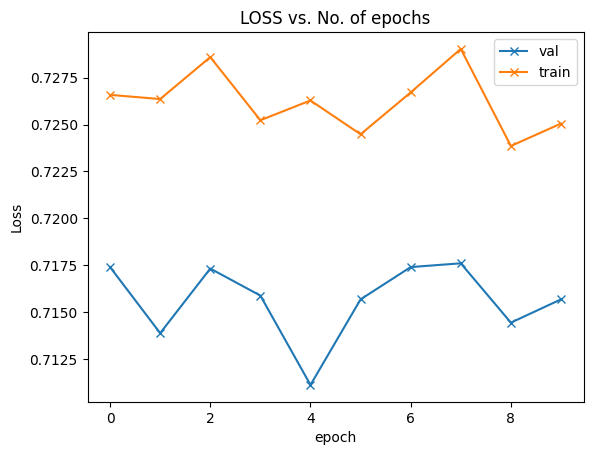

In [ ]:
plot_loss(history)

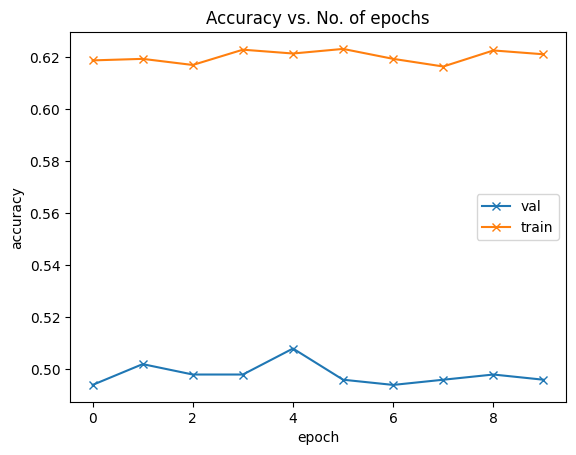

In [ ]:
plot_accuracies(history)

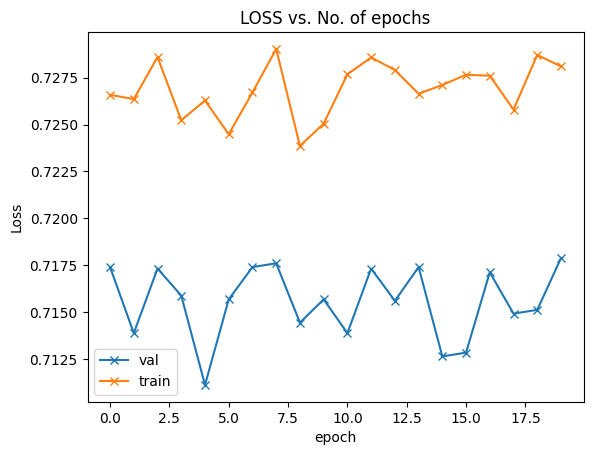

In [ ]:
plot_loss(history)

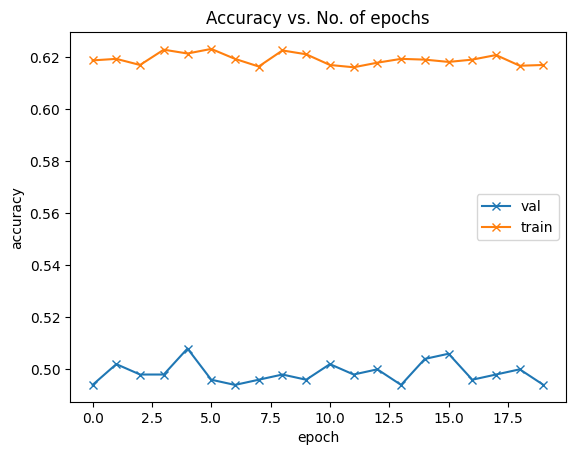

In [ ]:
plot_accuracies(history)

In [ ]:
history += train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch loss:  0.7240348880431231
Epoch [1/10], Train Loss: 0.7286, Train Acc: 0.6176, Val Loss: 0.7188, Val Acc: 0.4940
Epoch loss:  0.7278633226366604
Epoch [2/10], Train Loss: 0.7258, Train Acc: 0.6206, Val Loss: 0.7154, Val Acc: 0.4980
Epoch loss:  0.7245935430947472
Epoch [3/10], Train Loss: 0.7273, Train Acc: 0.6191, Val Loss: 0.7164, Val Acc: 0.4980
Epoch loss:  0.7299878966107088
Epoch [4/10], Train Loss: 0.7249, Train Acc: 0.6229, Val Loss: 0.7134, Val Acc: 0.5020
Epoch loss:  0.7245573728926041
Epoch [5/10], Train Loss: 0.7274, Train Acc: 0.6176, Val Loss: 0.7159, Val Acc: 0.4980
Epoch loss:  0.725081542519962
Epoch [6/10], Train Loss: 0.7297, Train Acc: 0.6162, Val Loss: 0.7144, Val Acc: 0.5020
Epoch loss:  0.727028635039049
Epoch [7/10], Train Loss: 0.7280, Train Acc: 0.6165, Val Loss: 0.7139, Val Acc: 0.5020
Epoch loss:  0.725569541945177
Epoch [8/10], Train Loss: 0.7295, Train Acc: 0.6176, Val Loss: 0.7210, Val Acc: 0.4920
Epoch loss:  0.724340500831604
Epoch [9/10], Train 

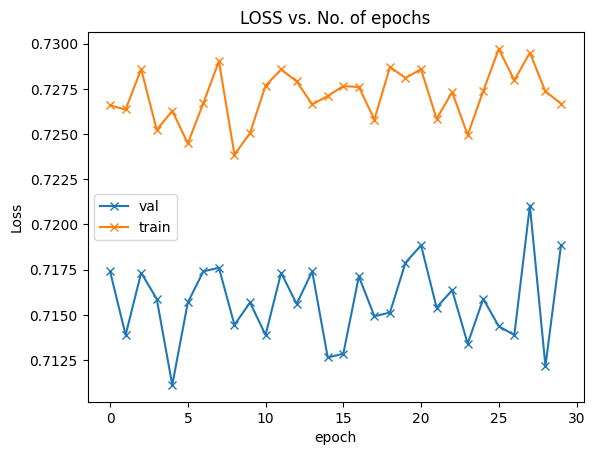

In [ ]:
plot_loss(history)

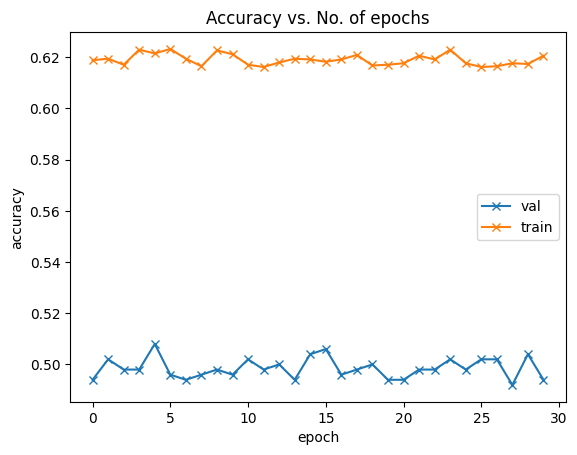

In [ ]:
plot_accuracies(history)

# part C

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [14]:
device = get_default_device()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

loadmodel = models.resnet50(pretrained=False)
num_ftrs = loadmodel.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(num_ftrs, 128),
#     nn.ReLU(),
#     nn.Linear(128, 1),
#     # nn.Sigmoid()

# )
loadmodel.fc = nn.Linear(num_ftrs, 1)
# create an instance of ResNet50
state_dict = torch.load('/content/drive/MyDrive/A4_q1_Resnet2.pth')

# load the saved model
loadmodel.load_state_dict(state_dict)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [16]:
loadmodel.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
dataset_test = CustomDataset(df_test, transform=transform)
test_data = torch.utils.data.DataLoader(dataset_test, batch_size=50, shuffle=True)

In [25]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
print(device)

cuda


In [26]:
test_data = DeviceDataLoader(test_data, device)


In [18]:
len(dataset_test)

1000

In [19]:
test_loader = test_data

In [18]:
def convert_output(output):
    output[output >= 0.5] = 1
    output[output <0.5] = 0
    
    return output.float()

In [22]:
def evaluate_all(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            labels = labels.view(-1, 1)
            
            outputs = convert_output(outputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 score:', f1)

    return accuracy, precision, recall, f1

In [23]:
import torch
from sklearn.metrics import accuracy_score, classification_report

def evaluate_class_wise(model, dataloader, device, num_classes):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            labels = labels.view(-1, 1)
            
            outputs = convert_output(outputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(num_classes)])

    print('Accuracy:', accuracy)
    print('Classification Report:')
    print(report)

    return accuracy, report


In [24]:
acc,pre,recall,f1_sc=evaluate_all(loadmodel, test_loader, device)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy: 0.496
Precision: 0.45569620253164556
Recall: 0.1469387755102041
F1 score: 0.22222222222222227


In [25]:
evaluate_class_wise(loadmodel, test_loader, device, 2)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy: 0.496
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.50      0.83      0.63       510
     Class 1       0.46      0.15      0.22       490

    accuracy                           0.50      1000
   macro avg       0.48      0.49      0.42      1000
weighted avg       0.48      0.50      0.43      1000



(0.496,
 '              precision    recall  f1-score   support\n\n     Class 0       0.50      0.83      0.63       510\n     Class 1       0.46      0.15      0.22       490\n\n    accuracy                           0.50      1000\n   macro avg       0.48      0.49      0.42      1000\nweighted avg       0.48      0.50      0.43      1000\n')

#Tnse

In [23]:
import numpy as np


In [30]:
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import seaborn as sns

def visualize_tsne(features, ground_labels):
    # extracting zero and one indexes numbers from labels
    zero_indices = [i for i, l in enumerate(ground_labels) if l == 0][:100]
    one_indices = [i for i, l in enumerate(ground_labels) if l == 1][:100]

    labels0 = ground_labels.take(zero_indices)
    labels1 = ground_labels.take(one_indices)
    labels = np.concatenate((labels0, labels1))

    features0 = features.take(zero_indices, axis=0)
    features1 = features.take(one_indices, axis=0)
    features_l = np.concatenate((features0, features1), axis=0)

    tsne = TSNE(n_components=1, verbose=1, random_state=123).fit_transform(features_l)

    df = pd.DataFrame()
    df["y"] = labels
    df["comp-1"] = tsne[:, 0]
    df["comp-2"] = 0  # Set to 0 since we only have 1 component
    sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                    palette=sns.color_palette("hls", 10),
                    data=df).set(title="Image Only Features TSNE Projections")


In [27]:
def postprocessing(data_loader, model, device):
    f1 = True
    f2 = True
    with torch.no_grad():
        for input, label in data_loader:
            input = input.to(device)
            output = model(input)
            output = torch.flatten(output, 1).detach().cpu().numpy()
            label = label.numpy()

            if f1:
                features = output
                f1 = False
            else:
                features = np.concatenate((features, output), axis=0)

            if f2:
                ground_labels = label
                f2 = False
            else:
                ground_labels = np.concatenate((ground_labels, label), axis=0)

    return features, ground_labels


In [28]:
features,ground_labels = postprocessing(test_loader,loadmodel)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


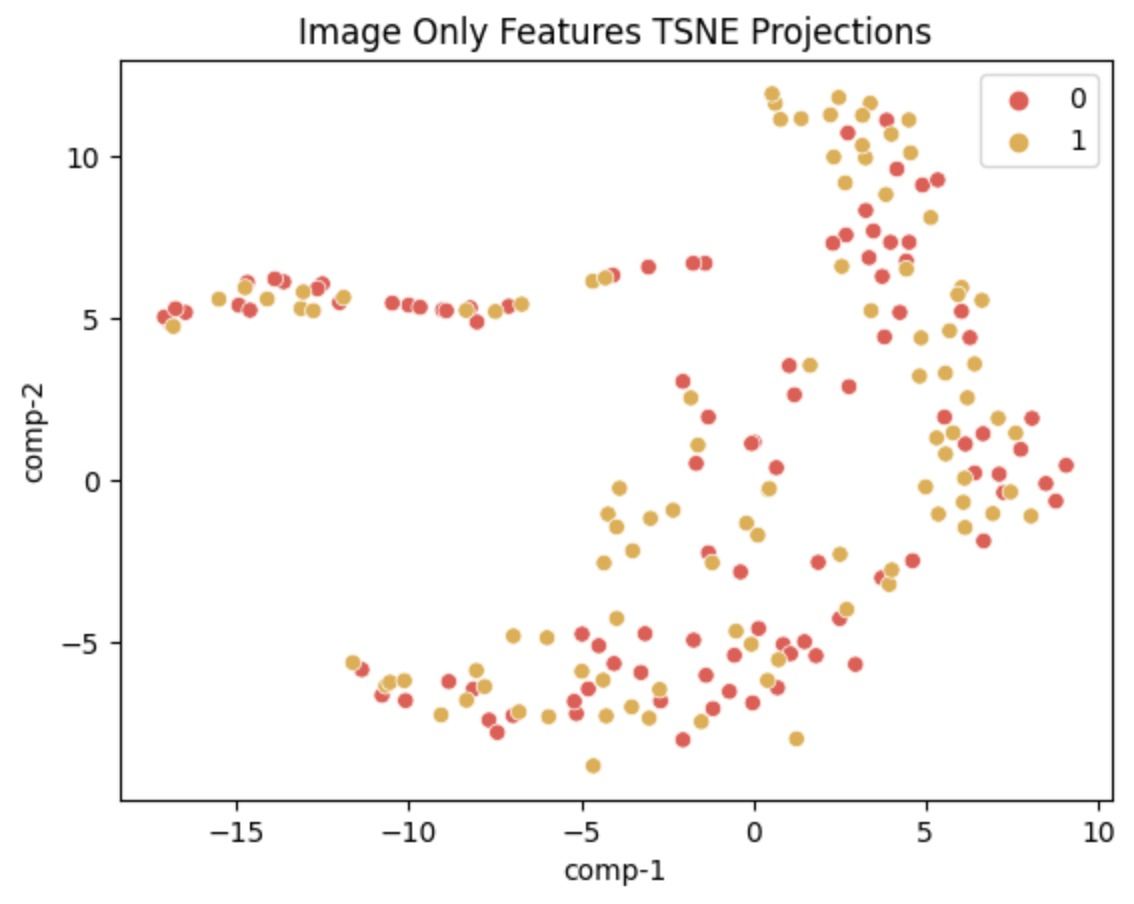

In [37]:
visualize_tsne(features,ground_labels)